# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [2]:
import numpy as np

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import matplotlib.pyplot as plt
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

# Question 1

**Explain how you solve the model**

<function matplotlib.pyplot.show(close=None, block=None)>

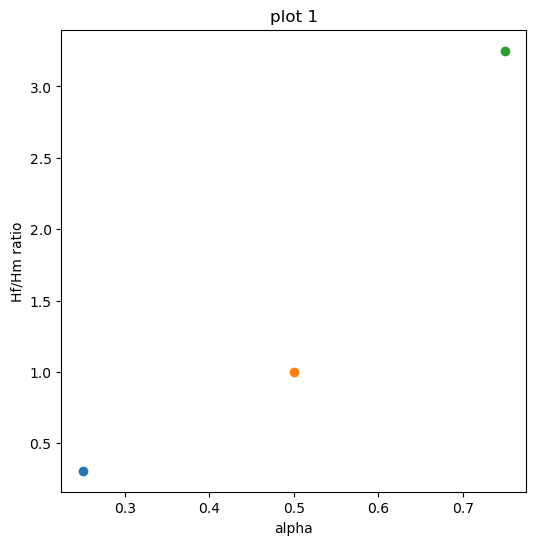

In [4]:
hsm = HouseholdSpecializationModelClass()

alpha_values = [0.25, 0.5, 0.75]

fig, ax = plt.subplots(figsize=(6, 6))

for alpha in alpha_values:
    hsm.par.alpha = alpha

    #solve the model
    opt = hsm.solve_discrete()

    #def the Hm/Hf ratio
    ratio = (opt.HF/opt.HM)

    #add data to scatterplot
    ax.scatter(alpha, ratio)

#define labels of the axes
ax.set_xlabel('alpha')
ax.set_ylabel('Hf/Hm ratio')
ax.set_title('plot 1')

#show plot
plt.show


# Question 2

Explain your code and procedure

In [1]:
# code

Y = 123

X = 456

Z = 890

# Question 3

Explain your code and procedure

In [ ]:
# code

ADD CONCISE CONLUSION.